# Cifar10 Outlier Demo with Kfserving

Prequisites:

 * Running cluster with kfserving installed and authenticated for use with `kubectl`
    * Istio with Istio Gateway exposed on a LoadBalancer
 * Knative eventing installed

## Setup Resources

Enabled eventing on default namespace. This will activate a default Knative Broker.

In [ ]:
!kubectl label namespace default knative-eventing-injection=enabled

Create a Knative service to dump events it receives. This will be the example final sink for outlier events.

In [2]:
!pygmentize message-dumper.yaml

apiVersion: serving.knative.dev/v1alpha1
kind: Service
metadata:
  name: message-dumper
spec:
  template:
    spec:
      containers:
      - image: gcr.io/knative-releases/github.com/knative/eventing-sources/cmd/event_display


In [3]:
!kubectl apply -f message-dumper.yaml

service.serving.knative.dev/message-dumper configured


Create the Kfserving image classification model for Cifar10. We add in a `logger` for requests - the default destination is the namespace Knative Broker.

In [6]:
!pygmentize cifar10.yaml

apiVersion: "serving.kubeflow.org/v1alpha2"
kind: "InferenceService"
metadata:
  name: "pytorch-cifar10"
spec:
  default:
    predictor:
      pytorch:
        storageUri: "gs://kfserving-samples/models/pytorch/cifar10/"
        modelClassName: "Net"
      logger:
        logType: request


In [7]:
!kubectl apply -f cifar10.yaml

inferenceservice.serving.kubeflow.org/pytorch-cifar10 created


Create the pretrained VAE Cifar10 Outlier Detector. We forward replies to the message-dumper we started.

In [11]:
!pygmentize cifar10od.yaml

apiVersion: serving.knative.dev/v1alpha1
kind: Service
metadata:
  name: vae-outlier
spec:
  template:
    spec:
      containers:
      - image: seldonio/cifar10od:0.0.1
        args:
        - --model_name
        - vaeod
        - --model_dir
        - ./examples/vae_outlier_detector/
        - --reply_url
        - http://message-dumper.default


In [12]:
!kubectl apply -f cifar10od.yaml

service.serving.knative.dev/vae-outlier created


Create a Knative trigger to forward logging events to our Outlier Detector.

In [13]:
!pygmentize trigger.yaml

apiVersion: eventing.knative.dev/v1alpha1
kind: Trigger
metadata:
  name: vaeoutlier-trigger
  namespace: default
spec:
  subscriber:
    ref:
      apiVersion: serving.knative.dev/v1alpha1
      kind: Service
      name: vae-outlier
      


In [14]:
!kubectl apply -f trigger.yaml

trigger.eventing.knative.dev/vaeoutlier-trigger created


Get the IP address of the Istio Ingress Gateway. This assumes you have installed istio with a LoadBalancer.

In [29]:
CLUSTER_IPS=!(kubectl -n istio-system get service istio-ingressgateway -o jsonpath='{.status.loadBalancer.ingress[0].ip}')
CLUSTER_IP=CLUSTER_IP[0]
print(CLUSTER_IP)

35.204.158.239


In [50]:
SERVICE_HOSTNAMES=!(kubectl get inferenceservice pytorch-cifar10 -o jsonpath='{.status.url}' | cut -d "/" -f 3)
SERVICE_HOSTNAME_CIFAR10=SERVICE_HOSTNAMES[0]
print(SERVICE_HOSTNAME_CIFAR10)

pytorch-cifar10.default.example.com


In [51]:
SERVICE_HOSTNAMES=!(kubectl get ksvc vae-outlier -o jsonpath='{.status.url}' | cut -d "/" -f 3)
SERVICE_HOSTNAME_VAEOD=SERVICE_HOSTNAMES[0]
print(SERVICE_HOSTNAME_VAEOD)

vae-outlier.default.example.com


In [77]:
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../../..')
import tensorflow as tf
tf.keras.backend.clear_session()
from odcd.models.losses import elbo
from odcd.od.vae import OutlierVAE
from odcd.utils.perturbation import apply_mask
from odcd.utils.saving import save_od, load_od
from odcd.utils.visualize import plot_instance_outlier, plot_feature_outlier_image
import requests

train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def pytorch_transform(X):
    img = (X - 0.5) * 2.0
    return np.transpose(img, (0,3, 1, 2))

def show(X):
    plt.imshow(X.reshape(32, 32, 3))
    plt.axis('off')
    plt.show()

def predict(X):
    X = pytorch_transform(X)
    formData = {
    'instances': X.tolist()
    }
    headers = {}
    headers["Host"] = SERVICE_HOSTNAME_CIFAR10
    res = requests.post('http://'+CLUSTER_IP+'/v1/models/pytorch-cifar10:predict', json=formData, headers=headers)
    if res.status_code == 200:
        return classes[np.array(res.json()["predictions"])[0].argmax()]
    else:
        print("Failed with ",res.status_code)
        return []
    
def outlier(X):
    X = pytorch_transform(X)
    formData = {
    'instances': X.tolist()
    }
    headers = {"odcd-return-feature-score":"true","odcd-return-instance-score":"true"}
    headers["Host"] = SERVICE_HOSTNAME_VAEOD
    res = requests.post('http://'+CLUSTER_IP+'/', json=formData, headers=headers)
    if res.status_code == 200:
        od = res.json()
        od["data"]["feature_score"] = np.array(od["data"]["feature_score"])
        od["data"]["instance_score"] = np.array(od["data"]["instance_score"])
        return od
    else:
        print("Failed with ",res.status_code)
        return []

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


## Normal Prediction

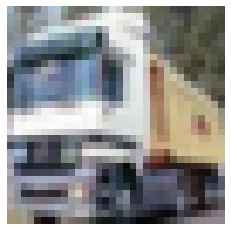

'truck'

In [42]:
idx = 1
X = X_train[idx:idx+1]
show(X)
predict(X)

Show logs from message-dumper

In [43]:
!kubectl logs $(kubectl get pod -l serving.knative.dev/configuration=message-dumper -o jsonpath='{.items[0].metadata.name}') user-container

☁️  cloudevents.Event
Validation: valid
Context Attributes,
  specversion: 0.2
  type: seldon.outlier
  source: seldon.ceserver.odcdserver.cifar10.vaeod
  id: 78163227-d881-40cd-9583-37587aeb8f9d
  contenttype: application/json
Data,
  "{\"data\": {\"is_outlier\": [0], \"feature_score\": null, \"instance_score\": null}, \"meta\": {\"name\": \"OutlierVAE\", \"detector_type\": \"offline\", \"data_type\": \"image\"}}"


## Outlier Prediction

In [44]:
 X_mask, mask = apply_mask(X.reshape(1, 32, 32, 3),
                                  mask_size=(20,20),
                                  n_masks=1,
                                  channels=[0,1,2],
                                  mask_type='normal',
                                  noise_distr=(0,1),
                                  clip_rng=(0,1))

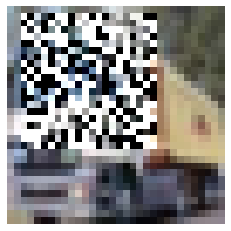

'truck'

In [46]:
show(X_mask)
predict(X_mask)

In [47]:
!kubectl logs $(kubectl get pod -l serving.knative.dev/configuration=message-dumper -o jsonpath='{.items[0].metadata.name}') user-container

☁️  cloudevents.Event
Validation: valid
Context Attributes,
  specversion: 0.2
  type: seldon.outlier
  source: seldon.ceserver.odcdserver.cifar10.vaeod
  id: 12f14ea6-9c24-4ded-aa02-e989dc88711c
  contenttype: application/json
Data,
  "{\"data\": {\"is_outlier\": [1], \"feature_score\": null, \"instance_score\": null}, \"meta\": {\"name\": \"OutlierVAE\", \"detector_type\": \"offline\", \"data_type\": \"image\"}}"


In [81]:
od_preds = outlier(X_mask)

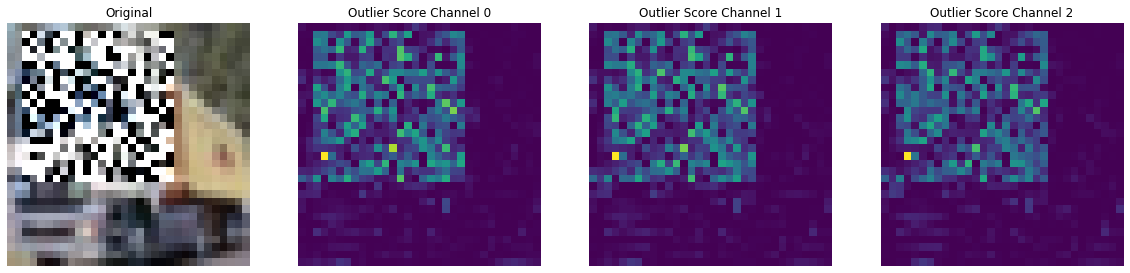

In [82]:
plot_feature_outlier_image(od_preds, 
                           X_mask, 
                           X_recon=None, 
                           max_outliers=X_mask.shape[0], 
                           n_channels=3)